In [1]:
import scanpy as sc

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=700,
    facecolor="white",
    vector_friendly=False,
    frameon=False,
)

import anndata2ri
import logging
import SEACells
from scipy.sparse import issparse
from scipy.sparse import csr_matrix, issparse

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
# For normalisation and feature selection 
library(scran)
library(BiocParallel)
library(scry)
###For differential analysis
library(dplyr)
library(DESeq2)

# Combine mesothelial scRNA-seq datasets together, normalise, select features, and reduce dimensions

In [13]:
# Load the heart mesothelium/epicardium dataset
heart = sc.read('/mnt/sdb/qdang/meso_project/heart_meso.h5ad')
heart

AnnData object with n_obs × n_vars = 649 × 15728
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'celltypist_cell_label_minglei', 'celltypist_conf_score_minglei', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltypist_cell_label

In [14]:
# Set the .X layer to soupX-corrected counts
heart.X = heart.layers['soupX_counts'].copy()

In [15]:
# Delete unneeded layers
del heart.layers['log1p_norm']
del heart.layers['analytic_pearson_residuals']
del heart.layers['scran_normalization']

In [16]:
# Load the lung mesothelium dataset
lung = sc.read('/mnt/sdb/qdang/singlecell/mesothelium/lung/PMID_36881507_embryoatlas/rna/meso_only.h5ad')
lung.X = lung.layers['soupX_counts'].copy()
lung

AnnData object with n_obs × n_vars = 224 × 17207
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'scDblFinder_class_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layer

In [18]:
del lung.layers['log1p_norm']
del lung.layers['scran_normalization']

In [19]:
pancreas = sc.read('/mnt/sdb/qdang/singlecell/mesothelium/pancreas/RNA/PMID_36881507_embryoatlas/meso_only.h5ad')
pancreas.X = pancreas.layers['soupX_counts'].copy()
pancreas

AnnData object with n_obs × n_vars = 550 × 18883
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'scDblFinder_class_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layer

In [21]:
del pancreas.layers['log1p_norm']
del pancreas.layers['scran_normalization']

In [22]:
import anndata as ad
meso = {"heart": heart, "lung": lung, "pancreas": pancreas}
adata = ad.concat(meso, label="tissue", join="outer")
adata

AnnData object with n_obs × n_vars = 1423 × 20250
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'celltypist_cell_label_minglei', 'celltypist_conf_score_minglei', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', 'tissue'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts', 'soupX_counts'

In [29]:
# Normalise and log1p-transform the data. Log1p normalisation is used for visualisation purposes and dimensional reduction. 
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [32]:
# Preliminary clustering for differentiated normalisation. This is required for scran normalisation, required for feature selection
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

2025-01-29 10:28:24.828270: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 10:28:25.268214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 10:28:25.268265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-29 10:28:25.345414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 10:28:25.495067: I tensorflow/core/platform/cpu_feature_guar

In [33]:
data_mat = adata_pp.X.T
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [35]:
# Compute size factors for scran normalisation
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [36]:
# Save size_factors in .obs and are now able to normalize the data and subsequently apply a log1p transformation.
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

In [4]:
# Save the AnnData object in the R environment.
ro.globalenv["adata"] = adata

In [5]:
# Call feature selection with deviance on the non-normalized counts matrix 
%%R
sce = devianceFeatureSelection(adata, assay="X")

In [6]:
# Export the binomial deviance values as a vector
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [7]:
# Sort the vector and select the top 4,000 highly deviant genes and save them as an additional column in .var as ‘highly_deviant'
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

In [10]:
# Set the .X layer to log1p-normalised data for PCA
adata.X = adata.layers["log1p_norm"]

In [11]:
# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata.var["highly_variable"] = adata.var["highly_deviant"]
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

2025-01-29 10:41:26.726469: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 10:41:26.756077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-29 10:41:26.756100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-29 10:41:26.756913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 10:41:26.761878: I tensorflow/core/platform/cpu_feature_guar

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


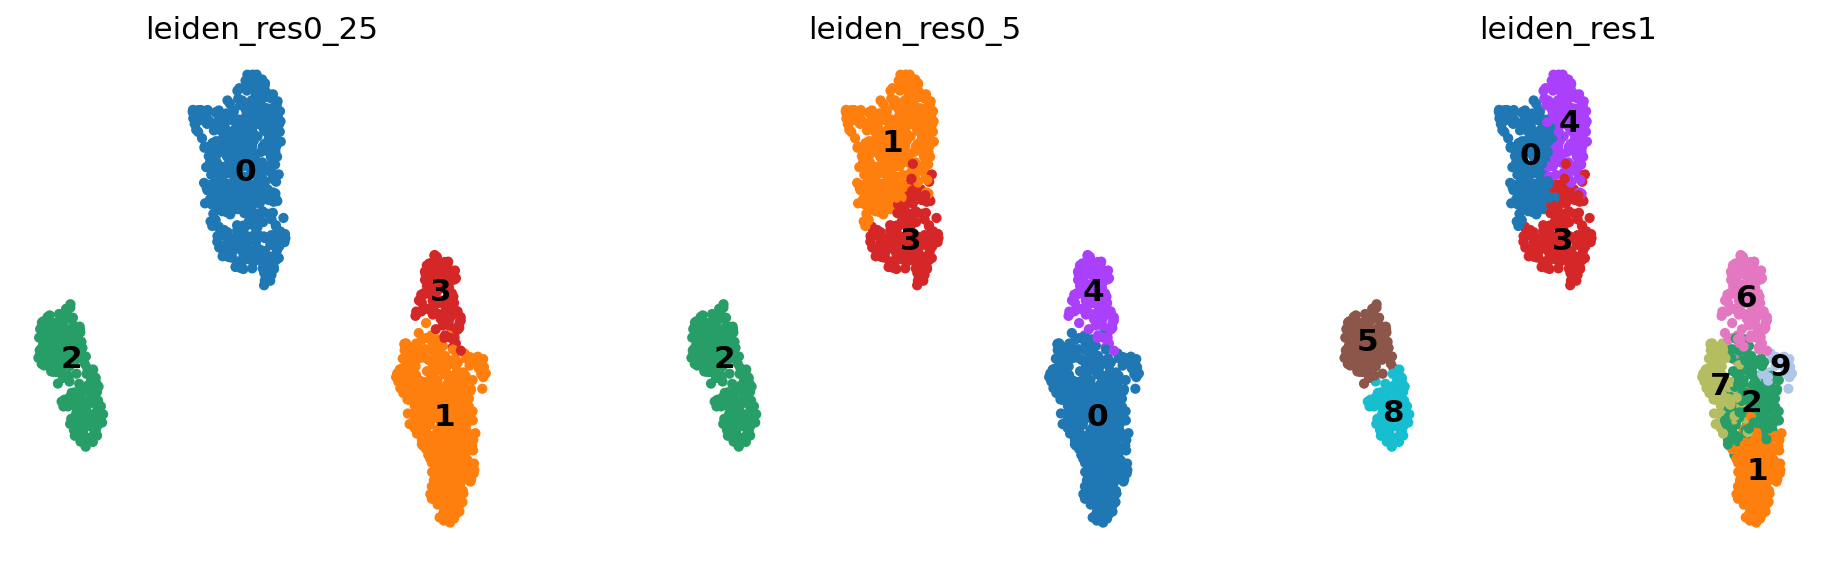

In [14]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

In [15]:
adata

AnnData object with n_obs × n_vars = 1423 × 20250
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'celltypist_cell_label_minglei', 'celltypist_conf_score_minglei', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', 'tissue'
    var: 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_nor

In [ ]:
adata.write('/mnt/sdb/qdang/meso_project/integrated_tissue_rna.h5ad')

# Differential analysis

### We first construct metacells using the SEACells algorithm

In [84]:
ad = sc.read('/mnt/sdb/qdang/meso_project/integrated_tissue_rna.h5ad')
ad

AnnData object with n_obs × n_vars = 1423 × 14151
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'celltypist_cell_label_minglei', 'celltypist_conf_score_minglei', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', 'tissue', 'cell_type'
    var: 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_res0_25_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm', '

In [85]:
# Perform the steps required for metacell computation
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
ad.X = ad.layers['soupX_counts']
raw_ad = sc.AnnData(ad.X)
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [ ]:
# Normalise cells and log1p-transform
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)

In [87]:
## Define parameter for metacell computation

## Core parameters 
n_SEACells = 17 # 75 cells/metacell as per the authors' instructions
build_kernel_on = 'X_umap' # key in ad.obsm to use for computing metacells
use_gpu = True

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [88]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [89]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/1423 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/1423 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/1423 [00:00<?, ?it/s]

Constructing CSR matrix...


/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


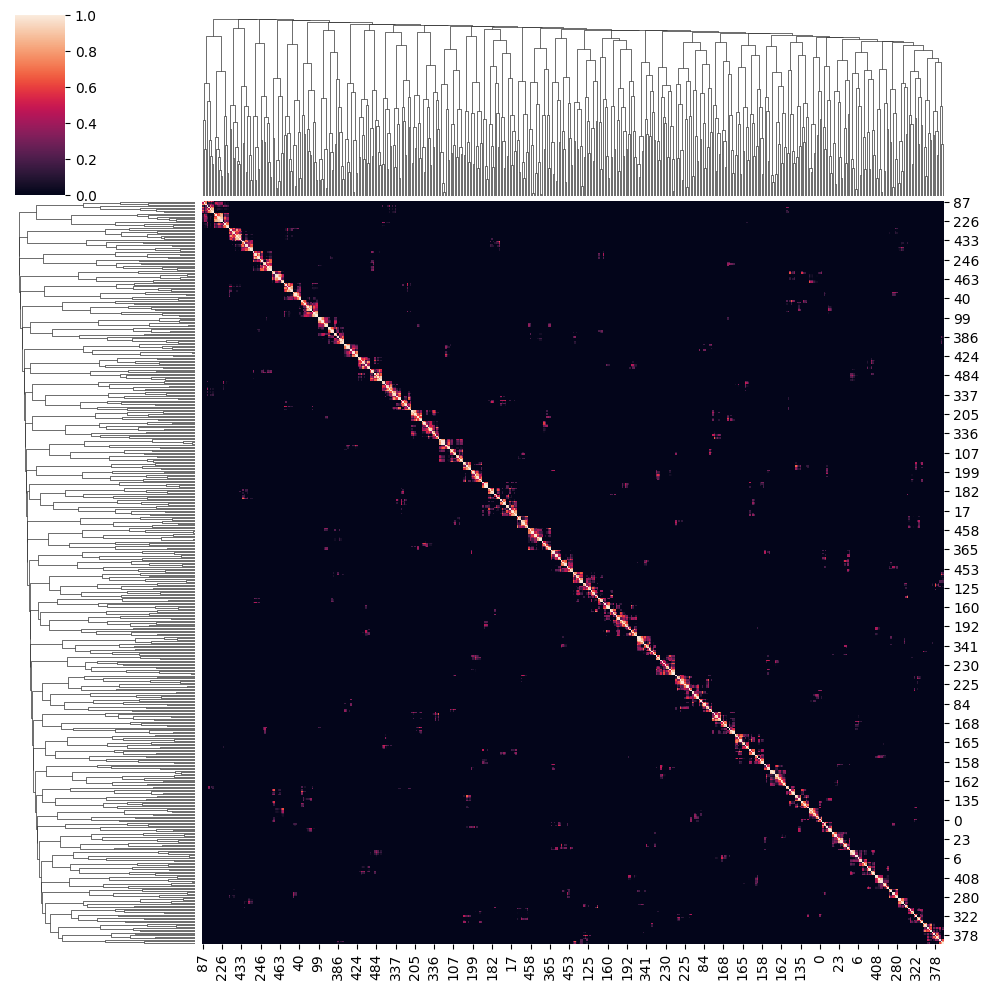

In [90]:
sns.clustermap(M.toarray()[:500,:500])

In [91]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_umap
Computing diffusion components from X_umap for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 9 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|███████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1354.73it/s]

Selecting 8 cells from greedy initialization.


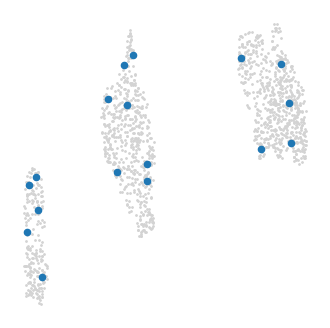

In [92]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ad, model)

In [93]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00074
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


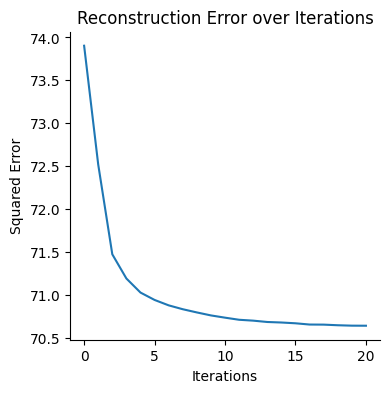

In [94]:
# Check for convergence 
model.plot_convergence()

In [95]:
ad.obs[['SEACell']].head()

,SEACell
index,
AAACCCAGTCCAGTTA-1,SEACell-3
AAACGAAGTAGGTCAG-1,SEACell-1
AAAGTCCGTTGCTCAA-1,SEACell-7
AAAGTGAAGGTCCTGC-1,SEACell-7
AAATGGAAGTGCTAGG-1,SEACell-9


In [98]:
# Confirm number of metacells and check the dimension of the anndata object (we will use these dimensions to check whether summation of metacells yield 
# the correct results. 
f'Number of SEACells: {ad.obs["SEACell"].unique().shape[0]}, Dimension of anndata: {ad.shape}'

'Number of SEACells: 17, Dimension of anndata: (1423, 14151)'

In [100]:
# Aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad

100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 162.56it/s]


AnnData object with n_obs × n_vars = 17 × 14151
    layers: 'raw'

In [102]:
# Copy over UMAp attributes from the original anndata object to the metacell anndata object
umap = pd.DataFrame(ad.obsm['X_umap'], index=ad.obs_names)
SEACell_ad.obsm['X_umap'] = umap.groupby(ad.obs['SEACell']).mean().loc[SEACell_ad.obs_names, :].values

In [103]:
# Identify most abundant tissue annotation for each SEACell
top_ct = ad.obs['tissue'].groupby(ad.obs['SEACell']).value_counts().groupby(level=0, group_keys=False).head(1)

ct_colors = dict(zip(ad.obs['tissue'].cat.categories, ad.uns['tissue_colors']))
SEACell_ad.obs['tissue'] = top_ct[SEACell_ad.obs_names].index.get_level_values(1)
SEACell_ad.uns['tissue_colors'] = [ct_colors[ct] for ct in SEACell_ad.obs['tissue'].cat.categories]

In [107]:
SEACell_ad

AnnData object with n_obs × n_vars = 17 × 14151
    obs: 'tissue'
    uns: 'tissue_colors'
    obsm: 'X_umap'
    layers: 'raw'

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/seaborn/relational.py:567: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


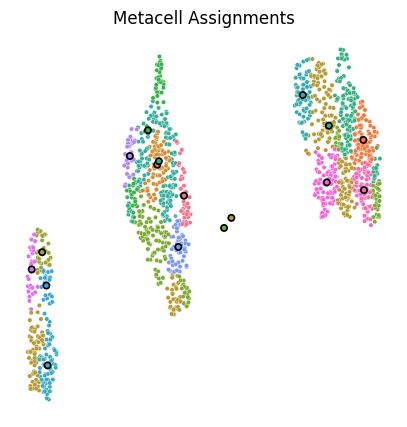

In [105]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

In [123]:
# Rename the index of the metacell anndata object (to generate sample ID for differential expression analysis later on)
SEACell_ad.obs['metacell'] = SEACell_ad.obs.index.copy()
SEACell_ad.obs['metacell'] = SEACell_ad.obs.index.copy()
SEACell_ad.obs['tissue'] = SEACell_ad.obs['tissue'].astype('object')
SEACell_ad.obs["sample"] = SEACell_ad.obs['metacell'] + SEACell_ad.obs['tissue']
SEACell_ad.obs.set_index('sample', inplace=True)
SEACell_ad.obs.index

Index(['SEACell-3heart', 'SEACell-1heart', 'SEACell-7heart', 'SEACell-9heart',
       'SEACell-16heart', 'SEACell-15heart', 'SEACell-5pancreas',
       'SEACell-4lung', 'SEACell-10lung', 'SEACell-14lung', 'SEACell-11lung',
       'SEACell-6pancreas', 'SEACell-8pancreas', 'SEACell-12pancreas',
       'SEACell-2pancreas', 'SEACell-0pancreas', 'SEACell-13pancreas'],
      dtype='object', name='sample')

In [131]:
# Normalise counts in the metacell dataset
SEACell_ad.layers['counts'] = SEACell_ad.X.copy()

# Normalize and log-transform
sc.pp.normalize_total(SEACell_ad, target_sum=1e4)
sc.pp.log1p(SEACell_ad)
SEACell_ad.layers['log1p_norm'] = SEACell_ad.X
SEACell_ad

AnnData object with n_obs × n_vars = 17 × 14151
    obs: 'tissue', 'metacell'
    uns: 'tissue_colors', 'log1p'
    obsm: 'X_umap'
    layers: 'raw', 'counts', 'log1p_norm'

In [142]:
###Save the count matrix in a format compatible with DESeq2
copy = SEACell_ad.copy()
copy.obs['sample'] =  copy.obs['tissue'].astype(str) + copy.obs['metacell']
copy.obs.set_index('sample', inplace=True)
matrix = copy.T.to_df()
matrix

sample,heartSEACell-3,heartSEACell-1,heartSEACell-7,heartSEACell-9,heartSEACell-16,heartSEACell-15,pancreasSEACell-5,lungSEACell-4,lungSEACell-10,lungSEACell-14,lungSEACell-11,pancreasSEACell-6,pancreasSEACell-8,pancreasSEACell-12,pancreasSEACell-2,pancreasSEACell-0,pancreasSEACell-13
0610009B22Rik,201.0,36.0,51.0,31.0,24.0,47.0,72.0,40.0,81.0,43.0,41.0,26.0,49.0,32.0,20.0,17.0,32.0
0610009E02Rik,20.0,0.0,2.0,0.0,0.0,0.0,22.0,4.0,11.0,9.0,4.0,10.0,43.0,18.0,21.0,16.0,5.0
0610009L18Rik,23.0,0.0,5.0,0.0,0.0,0.0,9.0,5.0,17.0,6.0,3.0,2.0,20.0,4.0,10.0,16.0,7.0
0610009O20Rik,24.0,12.0,15.0,20.0,15.0,14.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610010F05Rik,80.0,14.0,34.0,17.0,9.0,31.0,37.0,10.0,14.0,7.0,4.0,5.0,25.0,22.0,17.0,17.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Nd4,9220.0,3955.0,4628.0,3990.0,3168.0,4724.0,3119.0,449.0,814.0,446.0,296.0,541.0,1935.0,842.0,775.0,949.0,350.0
mt-Nd4l,5473.0,283.0,785.0,274.0,225.0,381.0,3955.0,1974.0,3627.0,1708.0,1422.0,1699.0,5868.0,2481.0,2662.0,2696.0,993.0
mt-Nd5,1910.0,544.0,658.0,523.0,453.0,586.0,1078.0,363.0,612.0,307.0,183.0,350.0,1233.0,582.0,507.0,625.0,224.0
mt-Nd6,268.0,161.0,170.0,158.0,124.0,125.0,146.0,60.0,97.0,29.0,26.0,54.0,129.0,60.0,44.0,69.0,23.0


In [189]:
# Save the matrix in the R environment
%%R -i matrix
head(matrix, 5)
countData <- matrix

              heartSEACell-3 heartSEACell-1 heartSEACell-7 heartSEACell-9
0610009B22Rik            201             36             51             31
0610009E02Rik             20              0              2              0
0610009L18Rik             23              0              5              0
0610009O20Rik             24             12             15             20
0610010F05Rik             80             14             34             17
              heartSEACell-16 heartSEACell-15 pancreasSEACell-5 lungSEACell-4
0610009B22Rik              24              47                72            40
0610009E02Rik               0               0                22             4
0610009L18Rik               0               0                 9             5
0610009O20Rik              15              14                 5             0
0610010F05Rik               9              31                37            10
              lungSEACell-10 lungSEACell-14 lungSEACell-11 pancreasSEACell-6
0610009B22R

## Perform differential expression analysis using DESeq2

In [200]:
%%R
#Run the Deseq2 pipeline
# Filter data where there’s 0 or 1 read count across all samples.
countData = countData[rowSums(countData)>50, ]
# Import metadata
colData = read.csv("meso_metadata.csv")
colData

# Set up the DESeqDataSet Object and run the DESeq pipeline
dds = DESeqDataSetFromMatrix(countData=countData,
                             colData=colData,
                             design=~tissue)
dds = DESeq(dds)
dds

res = results(dds, contrast=c("tissue", "lung", "heart"))
res = res[order(res$pvalue),]
summary(res)


out of 12496 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3093, 25%
LFC < 0 (down)     : 3097, 25%
outliers [1]       : 100, 0.8%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 110 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
In addition: Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors


In [201]:
%%R
# Save the differential expression analysis results
setwd('/mnt/sdb/qdang/meso_project/differential/lungvsheart')
ressigup <- res[which(res$log2FoldChange > 0 & res$padj < .05),]
ressig <- res[which(res$padj < .1),]
ressigdown <- res[which(res$log2FoldChange < 0 & res$padj < .05),]
write.csv(ressigup, file = "resup.csv")
write.csv(ressigdown, file = "resdown.csv")
write.csv(ressig, file = "ressig.csv")
write.csv(res, file = "res.csv")

In [208]:
%%R
setwd('/mnt/sdb/qdang/meso_project/differential/pancreasvsheart')
ressigup <- res[which(res$log2FoldChange > 0 & res$padj < .05),]
ressig <- res[which(res$padj < .1),]
ressigdown <- res[which(res$log2FoldChange < 0 & res$padj < .05),]
write.csv(ressigup, file = "resup.csv")
write.csv(ressigdown, file = "resdown.csv")
write.csv(ressig, file = "ressig.csv")
write.csv(res, file = "res.csv")

## The section below is to remove gene groups that are not of interest (pseudogenes, ribosomal genes etc.)

In [4]:
gene_names = ad.var_names

In [5]:
# Define gene groups and remove
prefixes_to_remove = ['Rps', 'Rpl', 'mt', 'Mrps','Mrpl']
suffix_to_remove = 'Rik'
mask = (~gene_names.str.startswith(tuple(prefixes_to_remove)) &
~gene_names.str.endswith(suffix_to_remove)  
)
adata_filtered = ad[:, mask].copy()
print(f"Original number of genes: {len(gene_names)}")
print(f"Filtered number of genes: {adata_filtered.n_vars}")

Original number of genes: 14151
Filtered number of genes: 13388


In [6]:
adata_filtered

AnnData object with n_obs × n_vars = 1423 × 13388
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_1', 'leiden_2', 'celltypist_cell_label_minglei', 'celltypist_conf_score_minglei', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', 'tissue', 'cell_type'
    var: 'n_cells', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_res0_25_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 